# Algo

## importer le dataset

In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("result_merged.csv", delimiter=',', low_memory=False)

In [2]:
df.shape

(97916, 26)

## Fonctions utils

In [3]:
import seaborn as sns
colors_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink']

def print_bar_plot_cluster(cluster_summary):

    clusters = cluster_summary['Cluster'].unique()
    cluster_colors = {cluster: colors_list[i] for i, cluster in enumerate(np.unique(clusters))}
    cluster_summary.columns = ['Cluster', 'Recency_Mean', 'Recency_Std', 'Frequency_Mean', 'Frequency_Std', 'Monetary_Mean', 'Monetary_Std', 'Review_score_Mean_Mean', 'Review_score_Mean_Std', 'payment_type_credit_card_Mean', 'payment_type_credit_card_Std',  'CustomerCount']

    plt.figure(figsize=(18, 18))

    for i, metric in enumerate(['Recency', 'Frequency', 'Monetary', 'Review_score_Mean', 'payment_type_credit_card'], 1):
        plt.subplot(3, 3, i)

        sns.barplot(data=cluster_summary, x='Cluster', y=f'{metric}_Mean', yerr=cluster_summary[f'{metric}_Std'], capsize=0.1, palette=cluster_colors)

        plt.title(f'Mean {metric} by Cluster')
        plt.ylabel(f'Mean {metric}')
        plt.xlabel('Cluster')

    plt.subplot(3, 3, 6)
    sns.barplot(data=cluster_summary, x='Cluster', y='CustomerCount', palette=cluster_colors)
    plt.title('Customer Count by Cluster')
    plt.ylabel('Customer Count')
    plt.xlabel('Cluster')

    # Personnalisez davantage le style du graphique si nécessaire
    sns.set_style("whitegrid")

    plt.tight_layout()
    plt.show()

def plot_combined_pca_normalized(principal_components, clusters, pca_components, feature_names):
    cluster_colors = {cluster: colors_list[i] for i, cluster in enumerate(np.unique(clusters))}
    plt.figure(figsize=(10, 8))

    norms = np.linalg.norm(principal_components, axis=1)
    normalized_principal_components = principal_components / np.max(norms)

    for cluster in np.unique(clusters):
        mask = clusters == cluster
        plt.scatter(normalized_principal_components[mask, 0], normalized_principal_components[mask, 1],
                    color=cluster_colors[cluster], label=f'Cluster {cluster}', alpha=0.7, s=50)

    circle = plt.Circle((0, 0), 1, color='gray', fill=False)
    plt.gca().add_patch(circle)

    for i, (x, y) in enumerate(zip(pca_components[0], pca_components[1])):
        plt.arrow(0, 0, x, y, color='r', alpha=0.5)
        plt.text(x, y, feature_names[i], color='b', ha='center', va='center')

    plt.xlabel(f'Axe 1 ({100 * pca.explained_variance_ratio_[0]:.2f}%)')
    plt.ylabel(f'Axe 2 ({100 * pca.explained_variance_ratio_[1]:.2f}%)')
    plt.title('Clusters et cercle de corrélation dans le plan principal de la PCA')
    plt.legend()
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.grid(linestyle='--', linewidth=0.5)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.show()

def plot_combined_pca_normalized_34(principal_components, clusters, pca_components, feature_names):
    cluster_colors = {cluster: colors_list[i] for i, cluster in enumerate(np.unique(clusters))}
    plt.figure(figsize=(10, 8))

    pc_3_4 = principal_components[:, 2:4]
    norms = np.linalg.norm(pc_3_4, axis=1)
    normalized_pc_3_4 = pc_3_4 / np.max(norms)

    for cluster in np.unique(clusters):
        mask = clusters == cluster
        plt.scatter(normalized_pc_3_4[mask, 0], normalized_pc_3_4[mask, 1],
                    color=cluster_colors[cluster], label=f'Cluster {cluster}', alpha=0.7, s=50)

    circle = plt.Circle((0, 0), 1, color='gray', fill=False)
    plt.gca().add_patch(circle)

    for i, (x, y) in enumerate(zip(pca_components[2], pca_components[3])):
        plt.arrow(0, 0, x, y, color='r', alpha=0.5)
        plt.text(x, y, feature_names[i], color='b', ha='center', va='center')

    plt.xlabel(f'Axe 3 ({100 * pca.explained_variance_ratio_[2]:.2f}%)')
    plt.ylabel(f'Axe 4 ({100 * pca.explained_variance_ratio_[3]:.2f}%)')
    plt.title('Clusters et cercle de corrélation dans le 3ème et 4ème plan principal de la PCA')
    plt.legend()
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.grid(linestyle='--', linewidth=0.5)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.show()

def print_tnse(rfm_tsne, clusters):
    cluster_colors = {cluster: colors_list[i] for i, cluster in enumerate(sorted(np.unique(clusters)))}
    point_colors = [cluster_colors[cluster] for cluster in clusters]
    plt.figure(figsize=(10, 8))
    plt.scatter(rfm_tsne[:, 0], rfm_tsne[:, 1], c=point_colors, alpha=0.7)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title('Clusters via t-SNE')
    plt.show()
    
def custom_sample(group):
    sample_size = 0.25
    n_samples = max(10, int(len(group) * sample_size))
    if len(group) < 20:
        return None
    return group.sample(n=n_samples)

## RFM

### Calculate RFM

In [4]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
reference_date = df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)
df['Recency'] = (reference_date - df['order_purchase_timestamp']).dt.days
df['Delivery_wait_days'] = (pd.to_datetime(df['order_delivered_customer_date']) - pd.to_datetime(df['order_purchase_timestamp'])).dt.days
print(df['Delivery_wait_days'].head(5))
rfm = df.groupby('customer_unique_id').agg({
    'Recency': 'min',
    'order_purchase_timestamp': 'count',
    'total_price_per_order': 'sum',
    'review_score': 'mean',
    'payment_type_credit_card': 'sum',
}).rename(columns={
    'order_purchase_timestamp': 'Frequency',
    'total_price_per_order': 'Monetary',
    'review_score': 'Review_score_Mean'
})
rfm = rfm.reset_index()
rfm.to_csv('rfm.csv', index=False)
print(rfm.columns)

0     7.0
1    16.0
2     7.0
3     6.0
4    25.0
Name: Delivery_wait_days, dtype: float64
Index(['customer_unique_id', 'Recency', 'Frequency', 'Monetary',
       'Review_score_Mean', 'payment_type_credit_card'],
      dtype='object')


In [5]:
rfm = rfm.groupby('Frequency', group_keys=False).apply(custom_sample).dropna()
rfm.to_csv('rfm_stratified.csv', index=False)
print(rfm)

                     customer_unique_id  Recency  Frequency  Monetary  \
45435  7a88128cf4f06d5ee259d5f410ffdd19      498          1     63.52   
34842  5dbcfd1a3cc694bfecc93ca15d884c9d      308          1    344.06   
12331  2121236c4b6dae7826b246ee636d7860      389          1     69.24   
60581  a3924db20da12f0e6e449c6c0a9b1824      367          1    119.94   
7204   134be76e0a726de8cd3fbf4ca184cc2f      128          1     50.68   
...                                 ...      ...        ...       ...   
29560  4facc2e6fbc2bffab2fea92d2b4aa7e4       21          4   1760.75   
3351   08e5b38d7948d37fbb2a59fc5e175ab1      117          4   1056.33   
66263  b2bd387fdc3cf05931f0f897d607dc88      182          4    638.77   
66569  b39dde6dd619943190a8cc9aa6db38a4      195          4    769.81   
65460  b08fab27d47a1eb6deda07bfd965ad43      349          4    477.34   

       Review_score_Mean  payment_type_credit_card  
45435               5.00                         1  
34842            

### Normaliser les valeurs RFM

In [6]:
rfm = pd.read_csv("rfm_stratified.csv",
                           delimiter=',',
                           low_memory=False)

scaler = StandardScaler()
numeric_columns = rfm.select_dtypes(include=[np.number])
rfm_normalized = scaler.fit_transform(numeric_columns)

## K-Means

### Déterminer le nombre optimal de clusters (k)

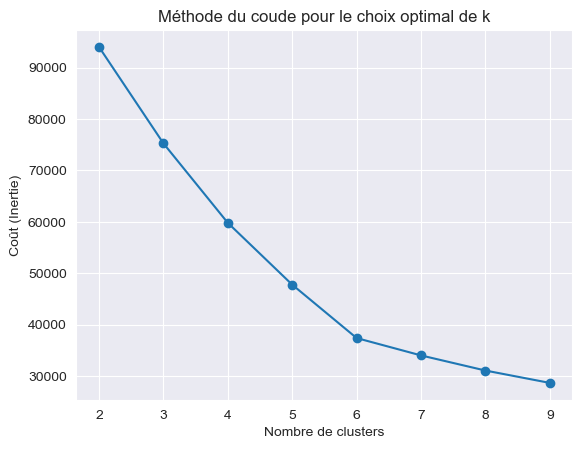

In [7]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

cost = []
silhouettes = []
dbis = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, n_init=20, init='k-means++', max_iter=300)
    kmeans.fit(rfm_normalized)
    cost.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(rfm_normalized, kmeans.labels_))
    dbis.append(davies_bouldin_score(rfm_normalized, kmeans.labels_))

plt.plot(range(2, 10), cost, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Coût (Inertie)')
plt.title('Méthode du coude pour le choix optimal de k')
plt.show()

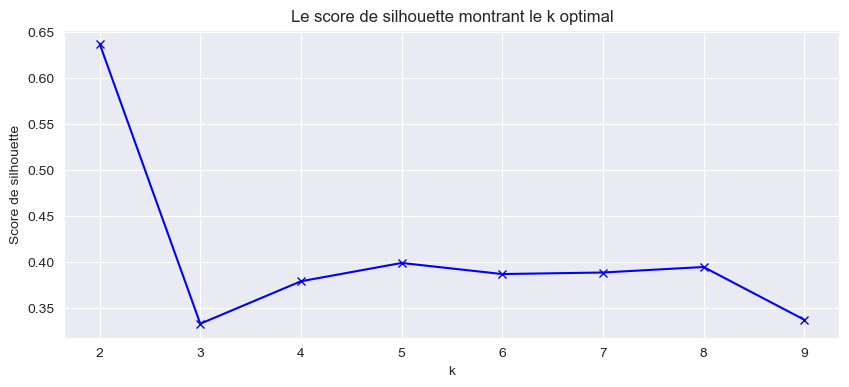

In [8]:
plt.figure(figsize=(10,4))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Score de silhouette')
plt.title('Le score de silhouette montrant le k optimal')
plt.show()

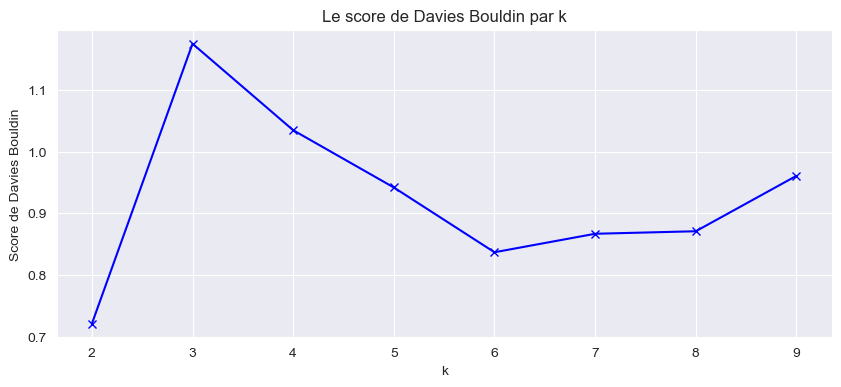

In [9]:
plt.figure(figsize=(10,4))
plt.plot(K, dbis, 'bx-')
plt.xlabel('k')
plt.ylabel('Score de Davies Bouldin')
plt.title('Le score de Davies Bouldin par k')
plt.show()

### Appliquer K-Means en évaluant la stabilité de l'initialisation

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time

sse_list = []
silhouette_scores = []
optimal_k = 5
execution_times = []
K = range(2, 10)
for k in K:
    start_time = time.time()
    kmeans = KMeans(n_clusters=optimal_k, n_init=20, init='k-means++', max_iter=300)
    clusters = kmeans.fit_predict(rfm_normalized)
    end_time = time.time()
    execution_time = end_time - start_time
    execution_times.append(execution_time)
    sse_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_normalized, clusters))

print("SSE: ", sse_list)
print("\n\nSilhouette Scores: ", silhouette_scores)
silhouette_mean = np.mean(silhouette_scores)
silhouette_std = np.std(silhouette_scores)
print("\n\nMoyenne des Silhouette Scores: ", silhouette_mean)
print("Écart type des Silhouette Scores: ", silhouette_std)

print("\n\nTemps d'exécution pour chaque itération:", execution_times)
mean_execution_times = sum(execution_times) / len(execution_times)
print(mean_execution_times)
print("\n\nTemps d'exécution moyen:", mean_execution_times)



SSE:  [47778.82202696627, 47778.784819303364, 47976.332810269385, 47976.33582544689, 47778.82202696627, 47778.822026966285, 47778.784819303364, 47778.78481930336]


Silhouette Scores:  [0.3987566187084462, 0.3987265218979307, 0.4090467876023507, 0.40905610418010674, 0.3987566187084462, 0.3987566187084462, 0.3987265218979307, 0.3987265218979307]


Moyenne des Silhouette Scores:  0.4013190392001985
Écart type des Silhouette Scores:  0.004464326714181247


Temps d'exécution pour chaque itération: [1.642838954925537, 1.8154239654541016, 1.6546900272369385, 1.5099289417266846, 1.1654150485992432, 0.9354701042175293, 2.574470043182373, 1.4334568977355957]
1.5914617478847504


Temps d'exécution moyen: 1.5914617478847504


### Appliquer K-Means avec la plus basse SSE (Sum of Squared Errors)

In [11]:
from joblib import dump, load

start_time = time.time()
best_index = np.argmin(sse_list)
best_kmeans = KMeans(n_clusters=optimal_k, n_init=20, init='k-means++', max_iter=300)
clusters = best_kmeans.fit_predict(rfm_normalized)
end_time = time.time()
execution_time = end_time - start_time
rfm['Cluster'] = clusters
dump(best_kmeans, 'best_kmeans_model.pkl')
np.save('best_kmeans_clusters.npy', clusters)

silhouette_score = silhouette_score(rfm_normalized, clusters)
dbi = davies_bouldin_score(rfm_normalized, kmeans.labels_)
print("\n\nTemps d'exécution de K-Means:", execution_time)
print("\\Score Silhouette", silhouette_score)
print("\\Score Davies Bouldin", dbi)



Temps d'exécution de K-Means: 1.4905080795288086
\Score Silhouette 0.3987265218979307
\Score Davies Bouldin 0.9416254645741653


### Visualiser K-Means avec PCA

In [12]:
pca = PCA()
pca.fit(rfm_normalized)
explained_variances = pca.explained_variance_
components_to_keep = np.sum(explained_variances > 1)
print(f"Variance expliquée: {explained_variances}")
print(f"Nombre de composantes à conserver selon le critère de Kaiser: {components_to_keep}")

Variance expliquée: [1.39640846 1.03849067 0.98981434 0.91021261 0.66528512]
Nombre de composantes à conserver selon le critère de Kaiser: 2


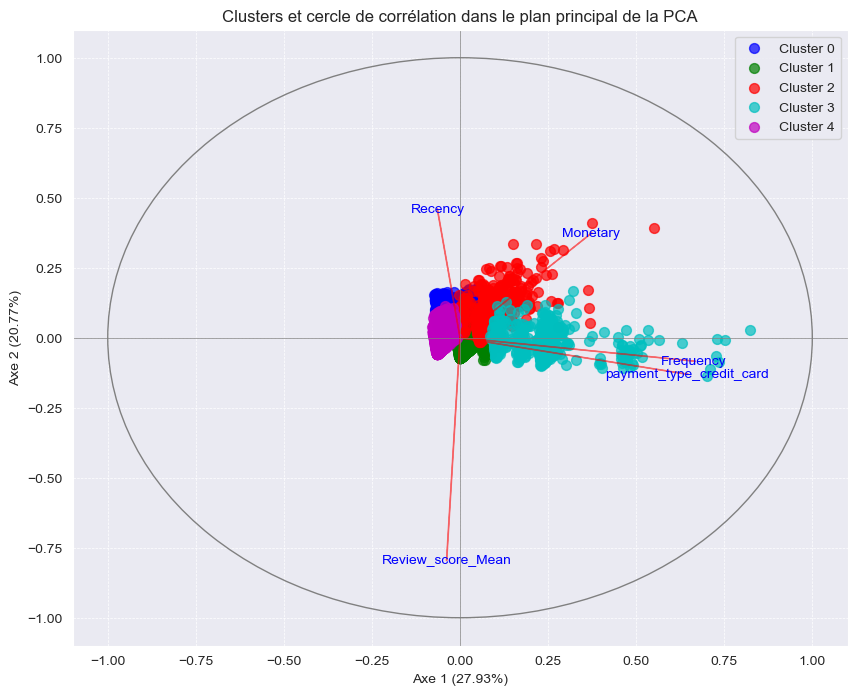

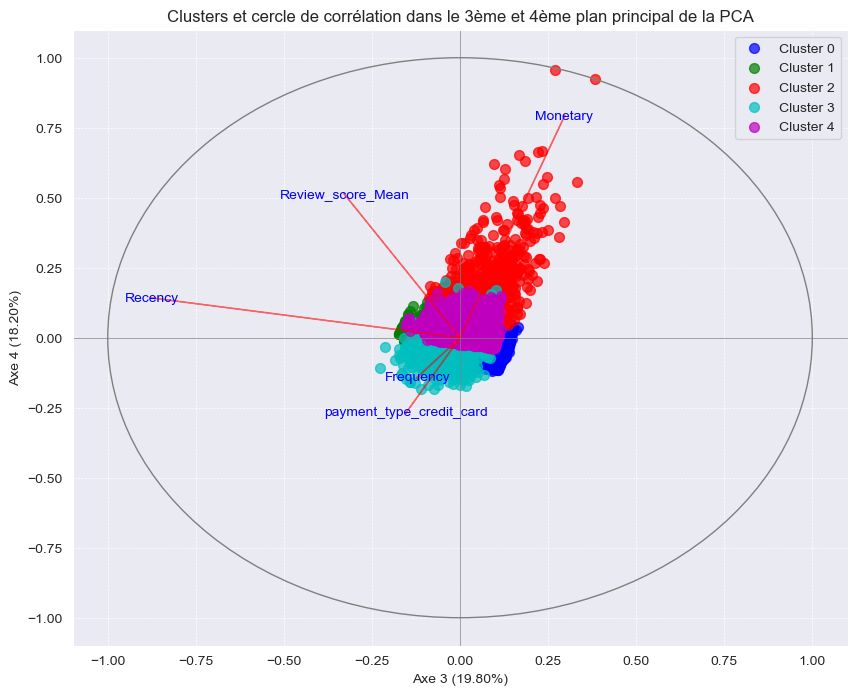

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
principal_components = pca.fit_transform(rfm_normalized)

correlation_circle_data = pca.components_
feature_names = numeric_columns.columns

plot_combined_pca_normalized(principal_components, clusters, correlation_circle_data, feature_names)
plot_combined_pca_normalized_34(principal_components, clusters, correlation_circle_data, feature_names)


### Visualiser K-Means avec TSNE

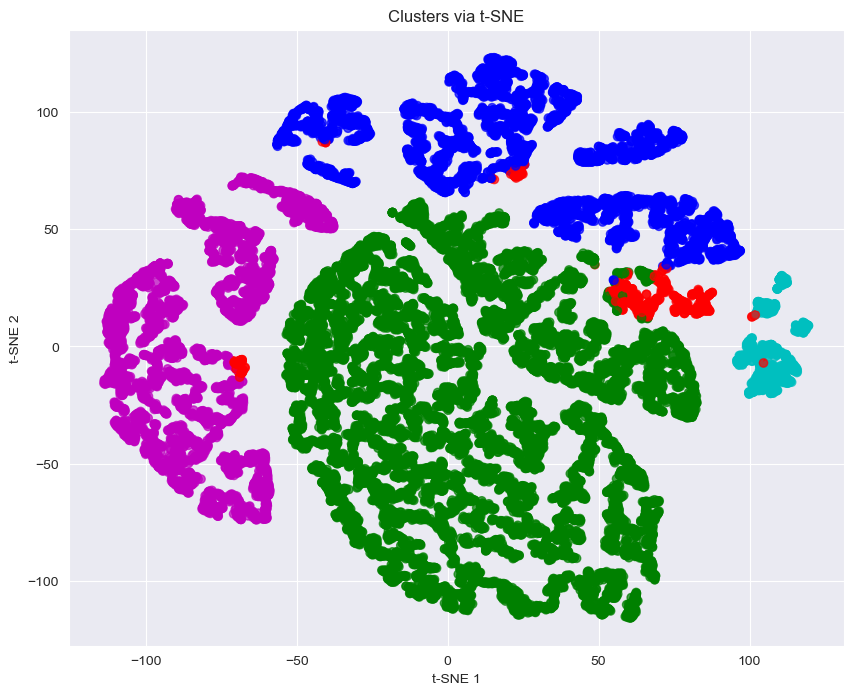

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
rfm_tsne = tsne.fit_transform(rfm_normalized)
print_tnse(rfm_tsne, clusters)

### Analyser K-Means

In [15]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Monetary': ['mean', 'std'],
    'Review_score_Mean': ['mean', 'std'],
    'payment_type_credit_card': ['mean', 'std'],
    'customer_unique_id': 'count'
}).reset_index()

print(cluster_summary)

  Cluster     Recency             Frequency               Monetary  \
                 mean         std      mean       std         mean   
0       0  250.199956  148.496929  1.000000  0.000000   149.970348   
1       1  240.353844  153.601766  1.000000  0.000000   135.782924   
2       2  237.537262  153.272165  1.017331  0.130615  1191.938527   
3       3  232.240057  144.788414  2.093750  0.336944   290.083438   
4       4  247.808530  156.143917  1.000000  0.000000   118.728714   

              Review_score_Mean           payment_type_credit_card            \
          std              mean       std                     mean       std   
0  124.311845          1.762179  0.891771                 0.841674  0.372890   
1  107.615314          4.741731  0.438209                 1.004097  0.063880   
2  553.615258          4.012132  1.414161                 0.856153  0.414705   
3  221.678997          4.121449  1.154096                 1.659091  0.838428   
4   99.659895          4.5692

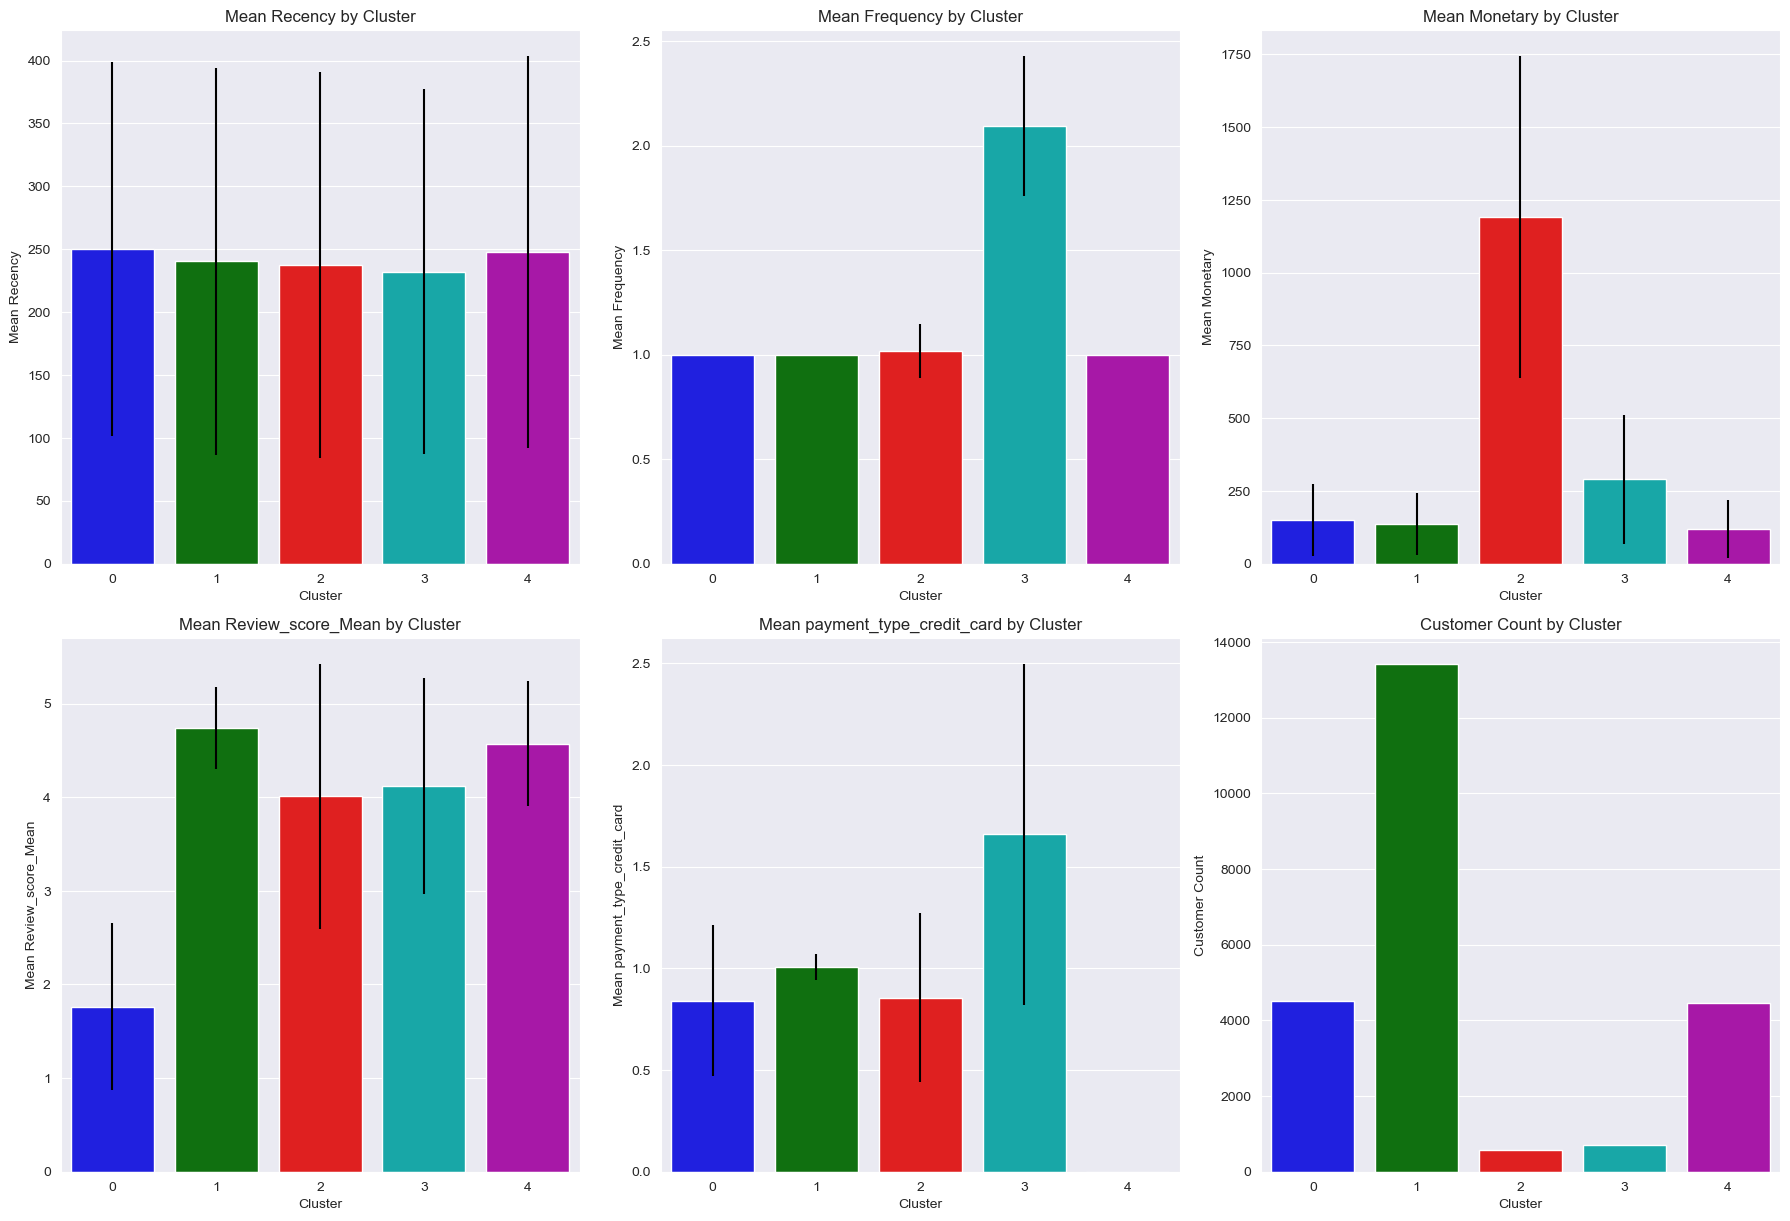

In [16]:
print_bar_plot_cluster(cluster_summary)

## Mini-Batch K-Means

### Déterminer le nombre optimal de clusters (k)

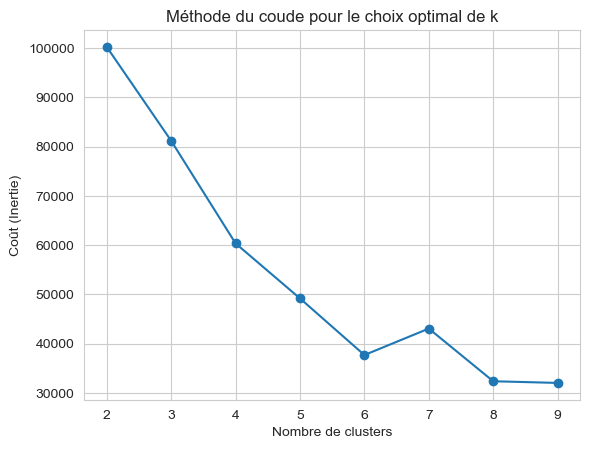

In [17]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

rfm = pd.read_csv("rfm_stratified.csv",
                  delimiter=',',
                  low_memory=False)

scaler = StandardScaler()
numeric_columns = rfm.select_dtypes(include=[np.number])
rfm_normalized = scaler.fit_transform(numeric_columns)

cost = []
silhouettes = []
dbis = []
K = range(2, 10)
for k in K:
    kmeans = MiniBatchKMeans(n_clusters=k, n_init=20, init='k-means++', max_iter=300, batch_size=100)
    kmeans.fit(rfm_normalized)
    cost.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(rfm_normalized, kmeans.labels_))
    dbis.append(davies_bouldin_score(rfm_normalized, kmeans.labels_))

plt.plot(range(2, 10), cost, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Coût (Inertie)')
plt.title('Méthode du coude pour le choix optimal de k')
plt.show()

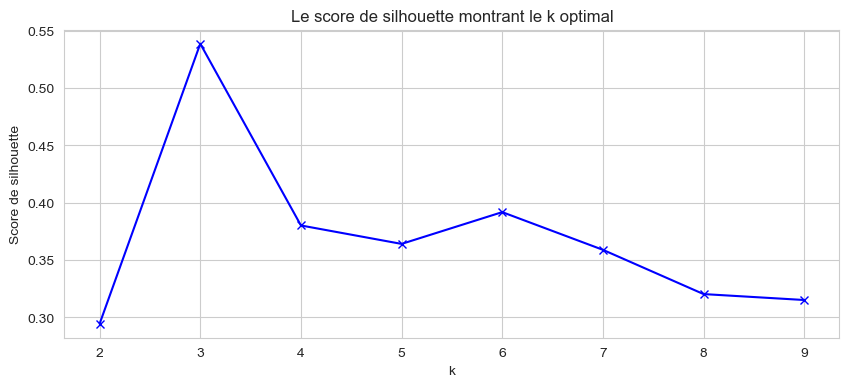

In [18]:
plt.figure(figsize=(10,4))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Score de silhouette')
plt.title('Le score de silhouette montrant le k optimal')
plt.show()

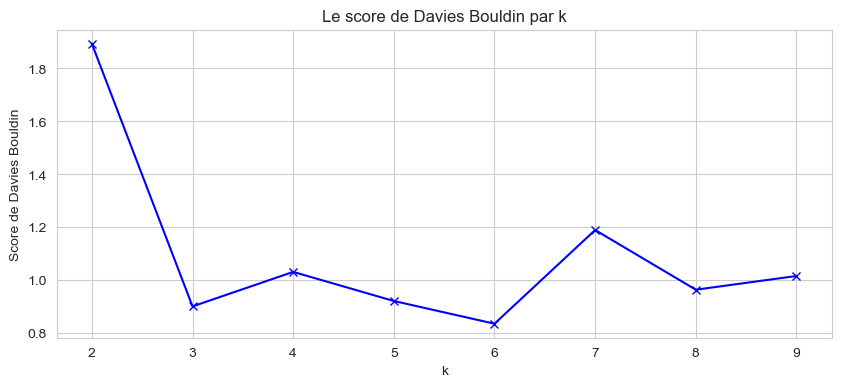

In [19]:
plt.figure(figsize=(10,4))
plt.plot(K, dbis, 'bx-')
plt.xlabel('k')
plt.ylabel('Score de Davies Bouldin')
plt.title('Le score de Davies Bouldin par k')
plt.show()

### Appliquer Mini-Batch K-Means en évaluant la stabilité de l'initialisation

In [20]:
import time

optimal_k = 5
n_init = 10
sse_list = []
silhouette_scores = []
execution_times = []

for i in range(n_init):
    start_time = time.time()
    kmeans = MiniBatchKMeans(n_clusters=optimal_k, n_init=1, init='k-means++', max_iter=300, batch_size=100)
    clusters = kmeans.fit_predict(rfm_normalized)
    end_time = time.time()
    execution_time = end_time - start_time
    execution_times.append(execution_time)
    sse_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_normalized, clusters))

print("SSE: ", sse_list)
print("Silhouette Scores: ", silhouette_scores)

silhouette_mean = np.mean(silhouette_scores)
silhouette_std = np.std(silhouette_scores)
print("\nMoyenne des Silhouette Scores: ", silhouette_mean)
print("Écart type des Silhouette Scores: ", silhouette_std)

print("\n\nTemps d'exécution pour chaque itération:", execution_times)
mean_execution_times = sum(execution_times) / len(execution_times)
print(mean_execution_times)
print("\n\nTemps d'exécution moyen:", mean_execution_times)

SSE:  [60087.04442286158, 50787.16530110279, 49625.076477112285, 51084.88962142624, 49262.500631299925, 50790.20038221014, 50879.24150948078, 48074.49721034398, 49773.79118459481, 49870.58935557118]
Silhouette Scores:  [0.34687248453221065, 0.3666863527939348, 0.3614231215869615, 0.32962952615582086, 0.36631836637534587, 0.3228813013513034, 0.33418622313235785, 0.3988506063865698, 0.38356343369578055, 0.30948659131495143]

Moyenne des Silhouette Scores:  0.3519898007325236
Écart type des Silhouette Scores:  0.026832959415403854


Temps d'exécution pour chaque itération: [0.007361173629760742, 0.13496017456054688, 0.11110711097717285, 0.14606213569641113, 0.13584494590759277, 0.129838228225708, 0.15493202209472656, 0.14295220375061035, 0.1272139549255371, 0.15281105041503906]
0.12430830001831054


Temps d'exécution moyen: 0.12430830001831054


### Appliquer Mini-Batch K-Means avec la plus basse SSE (Sum of Squared Error)

In [21]:
from joblib import dump

best_index = np.argmin(sse_list)
best_kmeans = MiniBatchKMeans(n_clusters=optimal_k, n_init=20, init='k-means++', max_iter=300, batch_size=100)
clusters = best_kmeans.fit_predict(rfm_normalized)
rfm['Cluster'] = clusters
dump(best_kmeans, 'best_mini_batch_kmeans_model.pkl')
np.save('best_mini_batch_kmeans_clusters.npy', clusters)

### Visualiser Mini-Batch K-Means avec PCA

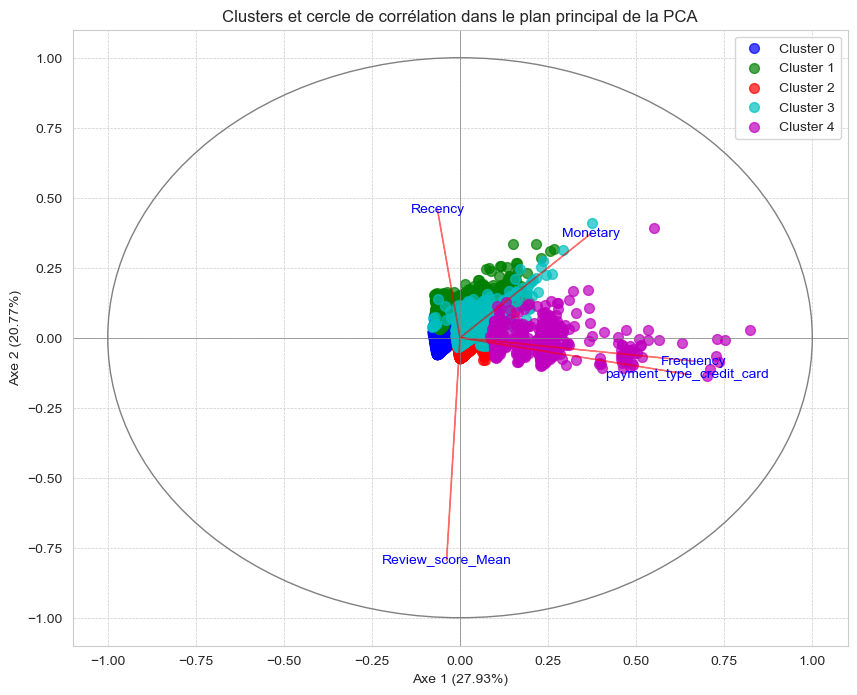

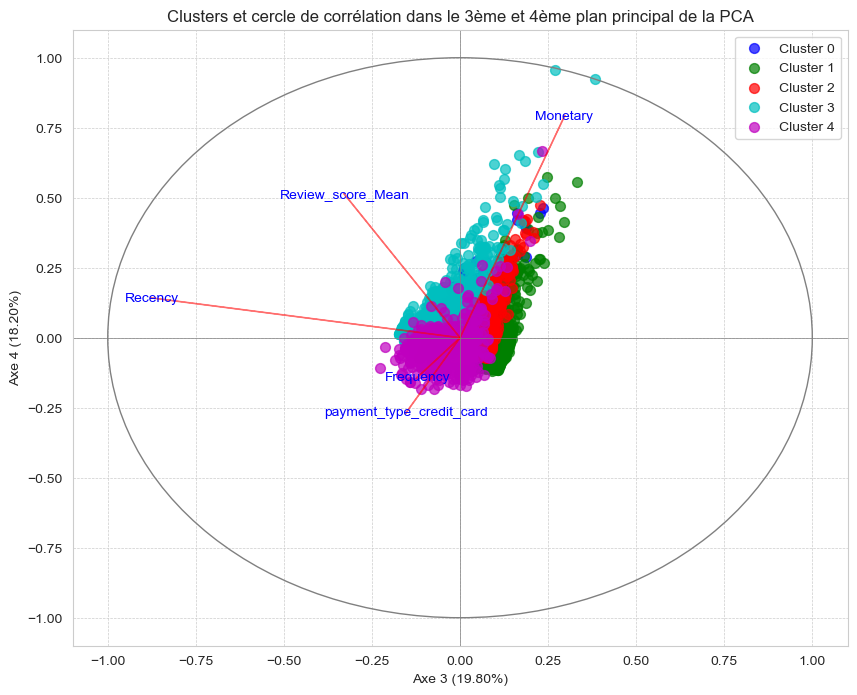

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
principal_components = pca.fit_transform(rfm_normalized)

correlation_circle_data = pca.components_
feature_names = numeric_columns.columns

plot_combined_pca_normalized(principal_components, clusters, correlation_circle_data, feature_names)
plot_combined_pca_normalized_34(principal_components, clusters, correlation_circle_data, feature_names)

### Visualiser Mini-Batch K-Means avec TNSE

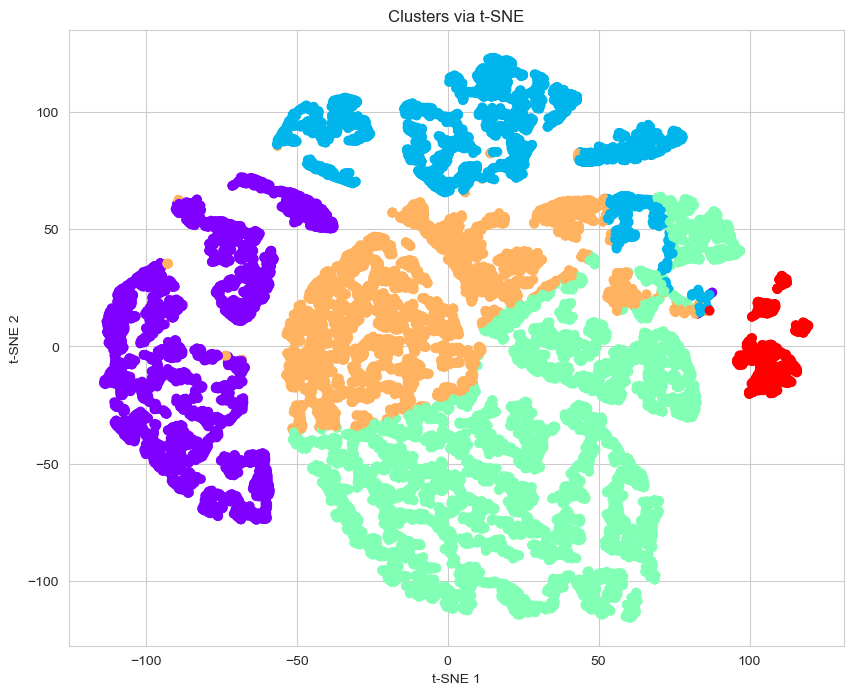

In [23]:
tsne = TSNE(n_components=2)
rfm_tsne = tsne.fit_transform(rfm_normalized)
plt.figure(figsize=(10, 8))
plt.scatter(rfm_tsne[:, 0], rfm_tsne[:, 1], c=clusters, cmap='rainbow')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Clusters via t-SNE')
plt.show()

### Analyser Mini-Batch K-Means

In [24]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Monetary': ['mean', 'std'],
    'Review_score_Mean': ['mean', 'std'],
    'payment_type_credit_card': ['mean', 'std'],
    'customer_unique_id': 'count',
}).reset_index()

print(cluster_summary)

  Cluster     Recency             Frequency              Monetary              \
                 mean         std      mean       std        mean         std   
0       0  246.120089  154.457030  1.000000  0.000000  131.518693  153.967042   
1       1  246.827901  138.717124  1.000000  0.000000  197.840008  271.372411   
2       2  141.949712   79.761175  1.000000  0.000000  147.147279  164.098866   
3       3  414.782058   90.948584  1.000000  0.000000  184.822141  270.593301   
4       4  231.584034  144.494318  2.092437  0.334754  313.245602  307.103315   

  Review_score_Mean           payment_type_credit_card            \
               mean       std                     mean       std   
0          4.569811  0.666420                 0.000000  0.000000   
1          1.412155  0.685190                 0.797238  0.411621   
2          4.635841  0.600772                 1.002983  0.054540   
3          4.593286  0.638420                 1.002385  0.104019   
4          4.109944  1.1

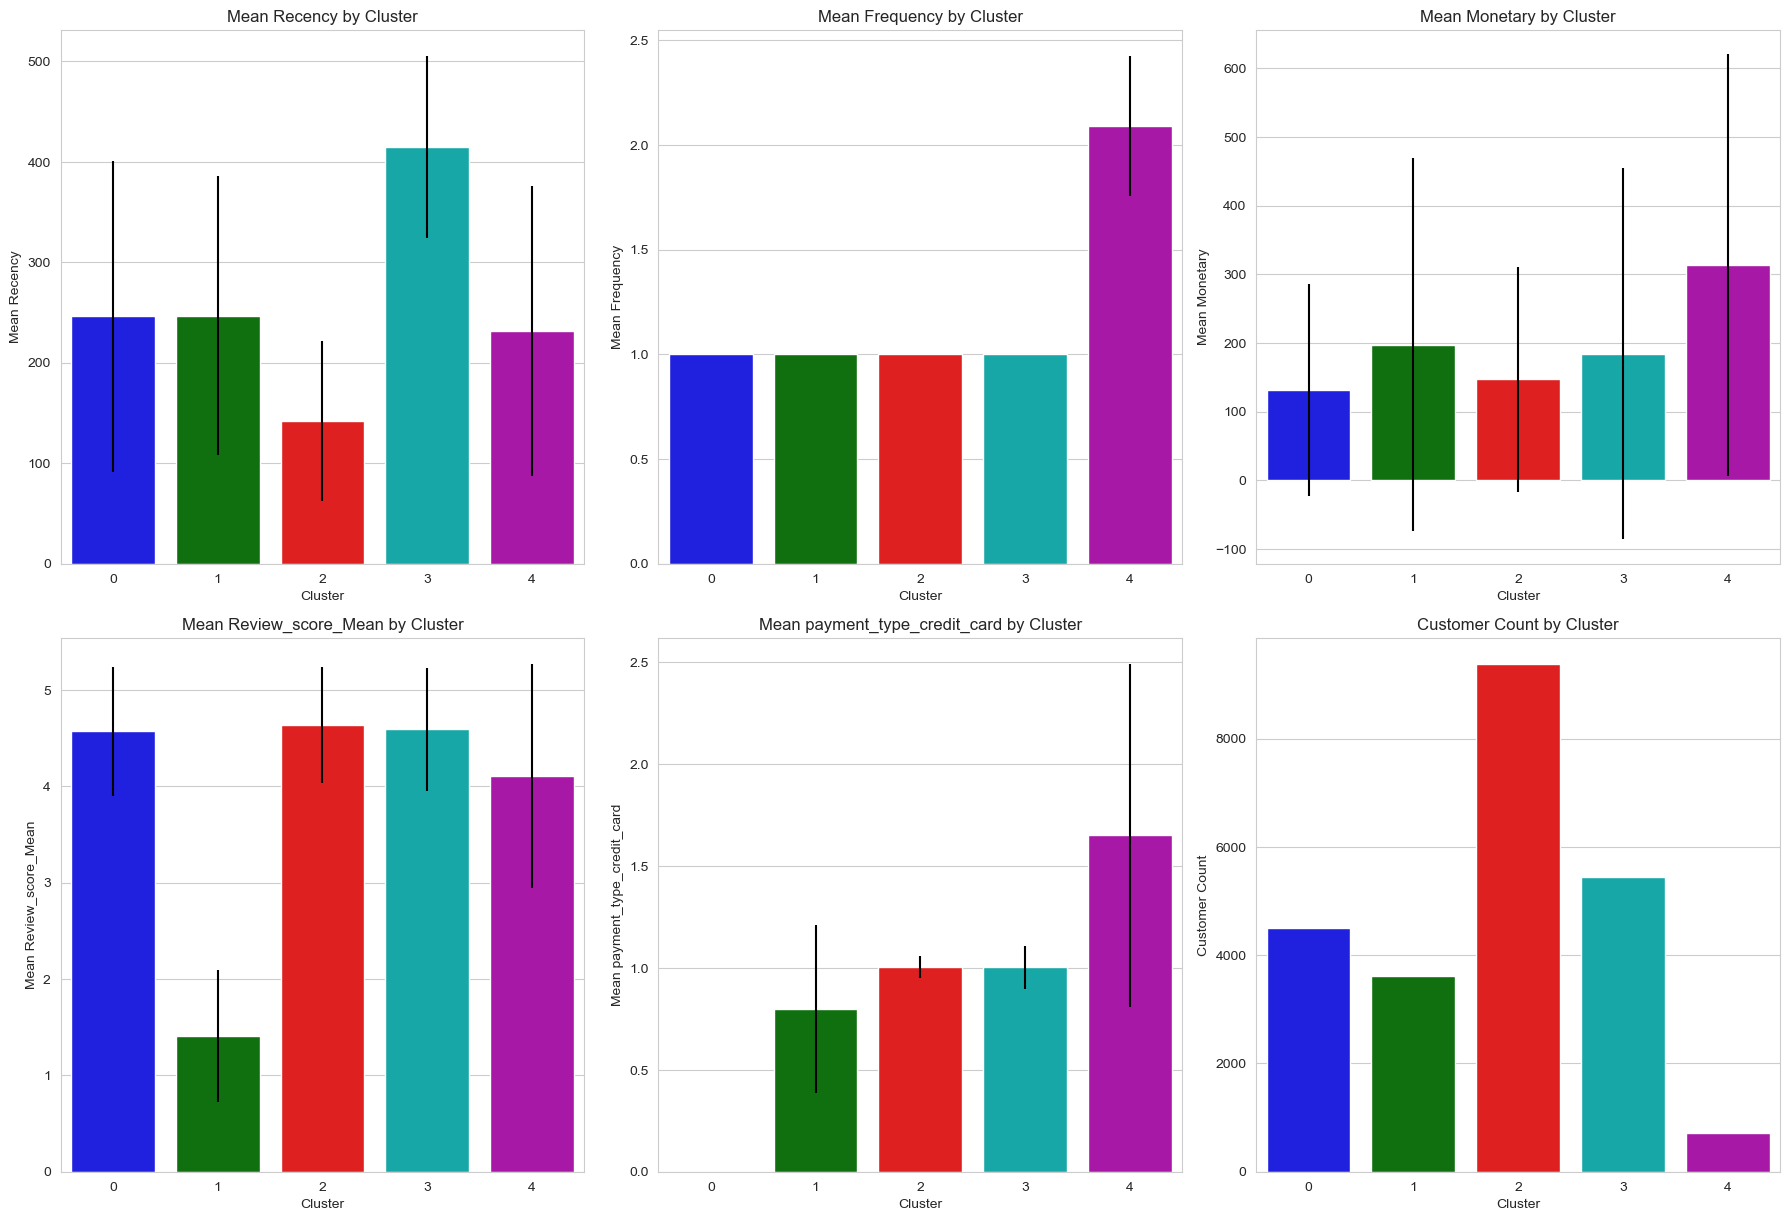

In [25]:
print_bar_plot_cluster(cluster_summary)

## DBScan

In [26]:
rfm = pd.read_csv("rfm_stratified.csv",
                  delimiter=',',
                  low_memory=False)

scaler = StandardScaler()
numeric_columns = rfm.select_dtypes(include=[np.number])
rfm_normalized = scaler.fit_transform(numeric_columns)

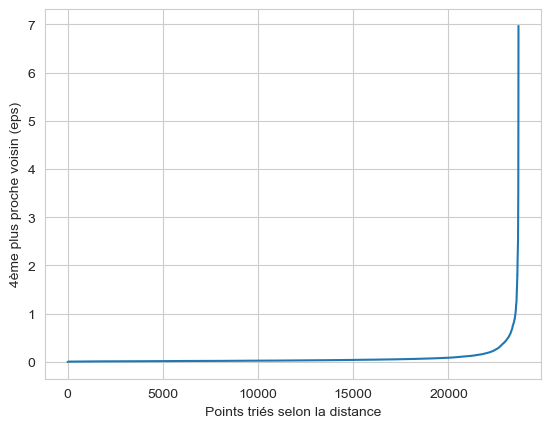

In [27]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

nearest_neighbors = NearestNeighbors(n_neighbors=4)
neighbors = nearest_neighbors.fit(rfm_normalized)

distances, indices = neighbors.kneighbors(rfm_normalized)
distances = np.sort(distances[:,3], axis=0)

plt.plot(distances)
plt.xlabel('Points triés selon la distance')
plt.ylabel('4ème plus proche voisin (eps)')
plt.show()

In [28]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

eps_value = 1

best_silhouette = -1
best_db = float('inf')
best_min_samples = None

for min_samples in range(2, 15):
    dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
    clusters_dbscan = dbscan.fit_predict(rfm_normalized)

    # Vérifier si tous les points n'ont pas été considérés comme du bruit
    if len(np.unique(clusters_dbscan)) > 1:
        silhouette = silhouette_score(rfm_normalized, clusters_dbscan)
        db = davies_bouldin_score(rfm_normalized, clusters_dbscan)

        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_min_samples = min_samples

        if db < best_db:
            best_db = db

print("Meilleur Silhouette Score : ", best_silhouette)
print("Meilleur Davies Bouldin Score : ", best_db)
print("Meilleur min_samples : ", best_min_samples)


Meilleur Silhouette Score :  0.3388116026316568
Meilleur Davies Bouldin Score :  1.2238077626837027
Meilleur min_samples :  6


In [29]:
dbscan = DBSCAN(eps=eps_value, min_samples=13)
clusters_dbscan = dbscan.fit_predict(rfm_normalized)
rfm['Cluster'] = clusters_dbscan
cluster_dbscan_summary = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Monetary': ['mean', 'std'],
    'Review_score_Mean': ['mean', 'std'],
    'payment_type_credit_card': ['mean', 'std'],
    'customer_unique_id': 'count'
}).reset_index()
print(cluster_dbscan_summary)

  Cluster     Recency             Frequency               Monetary  \
                 mean         std      mean       std         mean   
0      -1  250.540084  168.922017  1.767932  0.907213  1175.933249   
1       0  241.991334  152.362154  1.000000  0.000000   158.899757   
2       1  248.600038  155.156043  1.000000  0.000000   128.853091   
3       2  269.723404  156.424826  1.000000  0.000000   148.102553   
4       3  183.437500   68.619695  1.000000  0.000000  1694.912500   
5       4  235.231602  141.445039  2.000000  0.000000   253.382294   
6       5  251.470588  154.067903  2.000000  0.000000   205.459765   
7       6  180.764706  123.079582  2.000000  0.000000   227.122157   

              Review_score_Mean           payment_type_credit_card            \
          std              mean       std                     mean       std   
0  913.508794          3.472574  1.606472                 1.337553  1.133084   
1  174.419587          4.112201  1.322271                 1

## BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)

In [30]:
rfm = pd.read_csv("rfm_stratified.csv",
                  delimiter=',',
                  low_memory=False)

scaler = StandardScaler()
numeric_columns = rfm.select_dtypes(include=[np.number])
rfm_normalized = scaler.fit_transform(numeric_columns)

### Trouver les meilleurs hyperparamètres avec Birch

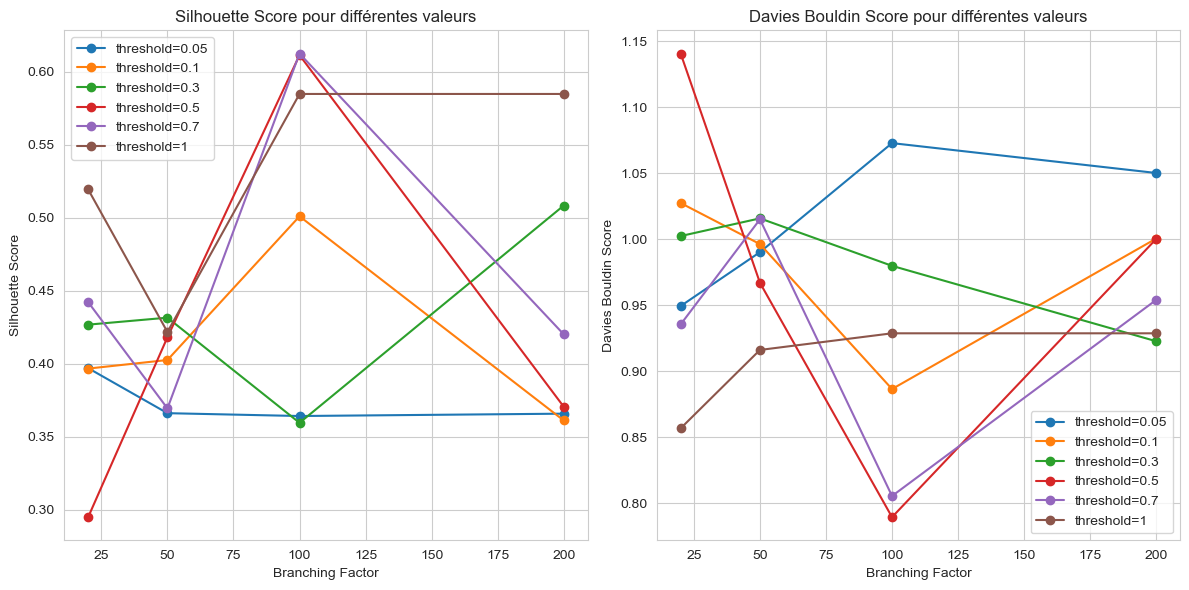

In [31]:
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score

threshold_range = [0.05, 0.1, 0.3, 0.5, 0.7, 1]
branching_factor_range = [20, 50, 100, 200]
results = []

for threshold in threshold_range:
    for branching_factor in branching_factor_range:
        brc = Birch(threshold=threshold, branching_factor=branching_factor, n_clusters=5, compute_labels=True)
        clusters_birch = brc.fit_predict(rfm_normalized)

        silhouette_score_birch = silhouette_score(rfm_normalized, clusters_birch)
        db_birch = davies_bouldin_score(rfm_normalized, clusters_birch)

        results.append({
            'threshold': threshold,
            'branching_factor': branching_factor,
            'silhouette_score': silhouette_score_birch,
            'davies_bouldin_score': db_birch
        })

df_results = pd.DataFrame(results)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for threshold in threshold_range:
    subset = df_results[df_results['threshold'] == threshold]
    plt.plot(subset['branching_factor'], subset['silhouette_score'], '-o', label=f'threshold={threshold}')
plt.title('Silhouette Score pour différentes valeurs')
plt.xlabel('Branching Factor')
plt.ylabel('Silhouette Score')
plt.legend()

plt.subplot(1, 2, 2)
for threshold in threshold_range:
    subset = df_results[df_results['threshold'] == threshold]
    plt.plot(subset['branching_factor'], subset['davies_bouldin_score'], '-o', label=f'threshold={threshold}')
plt.title('Davies Bouldin Score pour différentes valeurs')
plt.xlabel('Branching Factor')
plt.ylabel('Davies Bouldin Score')
plt.legend()

plt.tight_layout()
plt.show()


In [32]:
threshold = 0.05 # j'ai essayé différents paramètrse, et il y a toujours un soucis, des clusters beaucoup trop gros, et clusters beaucoup trop petit. Même en réduisant au maximum le threshold.
branching_factor = 100

start_time = time.time()
brc = Birch(threshold=threshold, branching_factor=branching_factor, n_clusters=5, compute_labels=True)
clusters_birch = brc.fit_predict(rfm_normalized)
end_time = time.time()
execution_time = end_time - start_time
rfm['Cluster'] = clusters_birch

silhouette_score_birch = silhouette_score(rfm_normalized, clusters_birch)
db_birch = davies_bouldin_score(rfm_normalized, clusters_birch)
print("\n\nTemps d'exécution de Birch:", execution_time)
print("Silhouette Score (BIRCH): ", silhouette_score_birch)
print("Score Davies Bouldin (BIRCH): ", db_birch)




Temps d'exécution de Birch: 1.6497461795806885
Silhouette Score (BIRCH):  0.36417976690092996
Score Davies Bouldin (BIRCH):  1.0728784822424458


### Analyser les clusters avec BIRCH

In [33]:
cluster_birch_summary = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Monetary': ['mean', 'std'],
    'Review_score_Mean': ['mean', 'std'],
    'payment_type_credit_card': ['mean', 'std'],
    'customer_unique_id': 'count'
}).reset_index()

print(cluster_birch_summary)

  Cluster     Recency             Frequency               Monetary  \
                 mean         std      mean       std         mean   
0       0  242.779495  152.549004  1.000000  0.000000   132.521954   
1       1  231.412017  144.733800  2.094421  0.338055   283.500429   
2       2  215.741228  144.245473  1.065789  0.248459  1685.986053   
3       3  248.647093  155.505335  1.000000  0.000000   120.376036   
4       4  237.364516  151.564931  1.000000  0.000000   755.885855   

              Review_score_Mean           payment_type_credit_card            \
          std              mean       std                     mean       std   
0   96.752056          4.114913  1.318630                 1.003834  0.061805   
1  207.982892          4.130901  1.143850                 1.659514  0.838682   
2  587.576529          3.780702  1.550238                 0.907895  0.445564   
3  102.396837          4.093297  1.332185                 0.000000  0.000000   
4  173.535798          4.0112

### Visualiser BIRCH avec TNSE

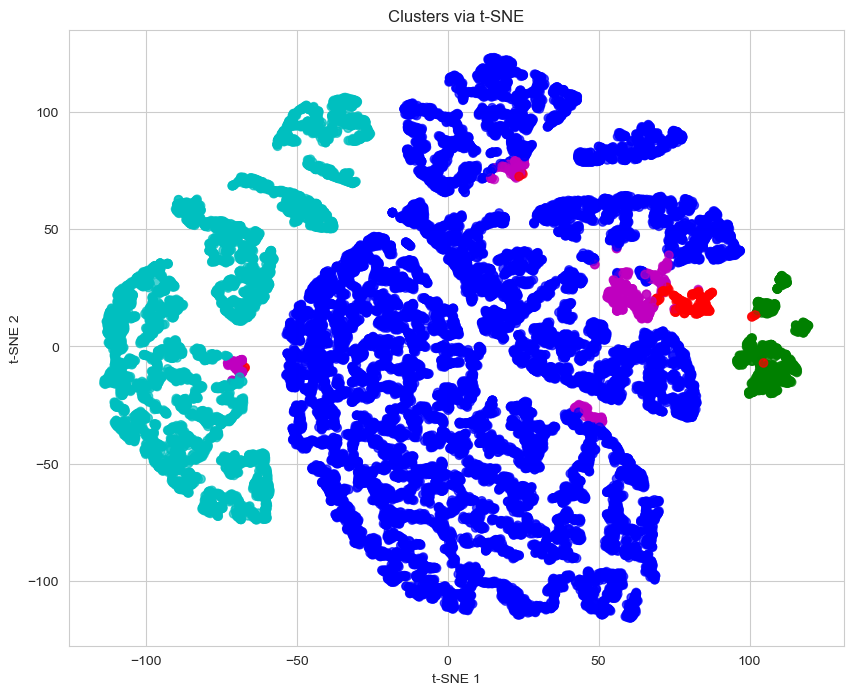

In [34]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
rfm_tsne = tsne.fit_transform(rfm_normalized)
print_tnse(rfm_tsne, clusters_birch)

## Clustering hiérarchique agglomératif (AHC)

In [35]:
rfm_ahc = pd.read_csv("rfm_stratified.csv",
                  delimiter=',',
                  low_memory=False)

scaler = StandardScaler()
numeric_columns = rfm_ahc.select_dtypes(include=[np.number])
rfm_normalized = scaler.fit_transform(numeric_columns)

### Déterminer le nombre optimal de clusters (n_clusters)

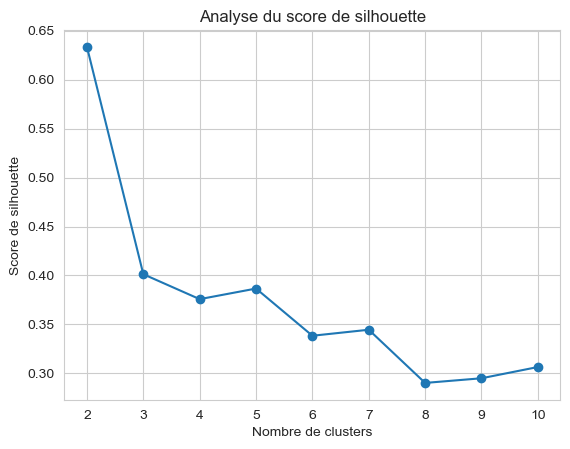

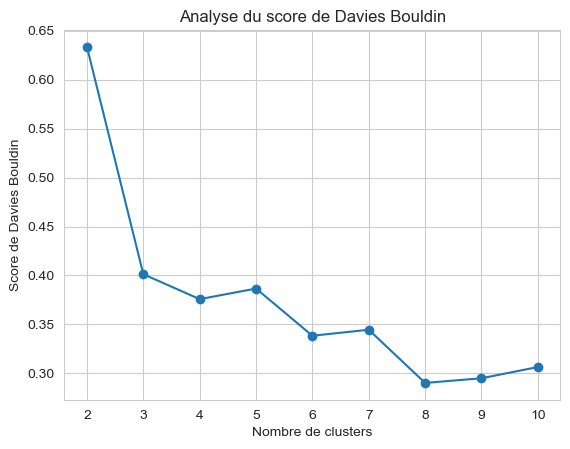

In [36]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

range_n_clusters = list(range(2,11))
silhouette_scores = []
dbi_ahc = []

for n_clusters in range_n_clusters:
    predicted_clusters_ahc = AgglomerativeClustering(n_clusters=n_clusters)
    preds_ahc = predicted_clusters_ahc.fit_predict(rfm_normalized)
    silhouette_score_ahc = silhouette_score(rfm_normalized, preds_ahc)
    silhouette_scores.append(silhouette_score_ahc)
    db_ahc = davies_bouldin_score(rfm_normalized, preds_ahc)
    dbi_ahc.append(silhouette_score_ahc)

plt.plot(range_n_clusters, silhouette_scores, 'o-')
plt.title('Analyse du score de silhouette')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.show()

plt.plot(range_n_clusters, dbi_ahc, 'o-')
plt.title('Analyse du score de Davies Bouldin')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de Davies Bouldin')
plt.show()

### Dendrogramme

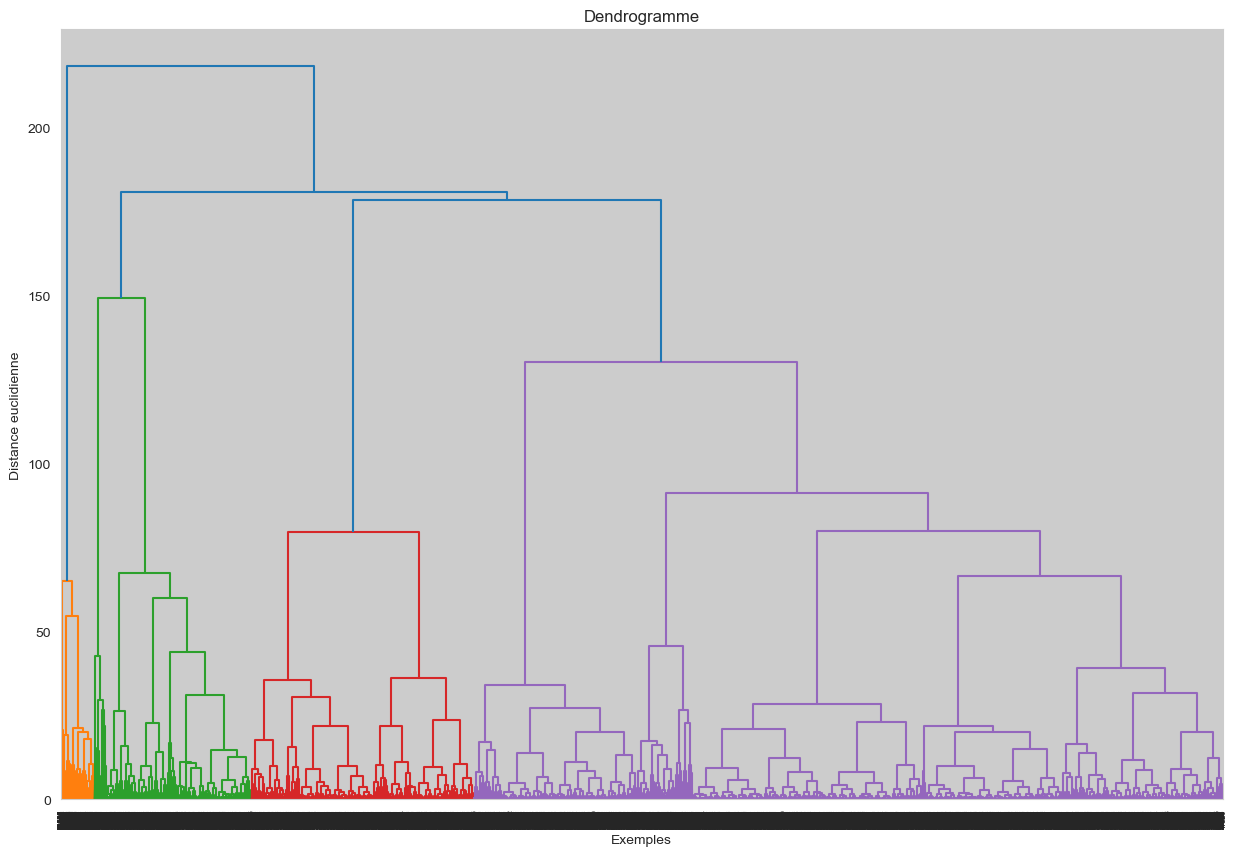

In [37]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(15, 10))
dendrogram = sch.dendrogram(sch.linkage(rfm_normalized, method='ward'))
plt.title('Dendrogramme')
plt.xlabel('Exemples')
plt.ylabel('Distance euclidienne')
plt.show()

In [38]:
start_time = time.time()
predicted_clusters_ahc = AgglomerativeClustering(n_clusters=5)
preds_ahc = predicted_clusters_ahc.fit_predict(rfm_normalized)
end_time = time.time()
execution_time = end_time - start_time

silhouette_score_ahc = silhouette_score(rfm_normalized, preds_ahc)
db_ahc = davies_bouldin_score(rfm_normalized, preds_ahc)

print("\n\nTemps d'exécution de AHC:", execution_time)
print("Silhouette Score (AHC): ", silhouette_score_ahc)
print("Score Davies Bouldin (AHC): ", db_ahc)




Temps d'exécution de AHC: 8.96820878982544
Silhouette Score (AHC):  0.386682647762328
Score Davies Bouldin (AHC):  0.9001926276923344
